<b><font color='darkred'>
SVM - Support Vector Machines
-----------------
➔ SVC & SVR mit Hyperparametersuche und Erzeugung synthetischer Daten

- Suche nach der optimaler Subsampling-Länge

In [ ]:
import numpy as np
from sklearn import model_selection, svm, metrics
import tsgm
import matplotlib.pyplot as plt
import matplotlib
import helper

In [4]:
SCALE = 2000

synthetic_data = True

In [5]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data()

<b><font color='lightgreen'> Validierungsdaten aus Trainingsdaten definieren

In [6]:
versuche_train_valid, versuche_test_valid = model_selection.train_test_split(versuche_train, test_size=0.1)
versuche_train_valid

,key,nr,label,label_name,festigkeit
213,near_ok_sonowechsel_2982,2982,1,NEAR-OK-Sonotrodenwechsel,2617.039062
48,fehler_terminversatz_2451,2451,4,Terminalversatz,1972.781982
222,near_ok_sonowechsel_3026,3026,1,NEAR-OK-Sonotrodenwechsel,2579.534912
76,fehler_leitungsversatz_2582,2582,3,Leitungsversatz,2532.566406
471,near_ok_sonowechsel_2943,2943,1,NEAR-OK-Sonotrodenwechsel,2214.447510
...,...,...,...,...,...
172,near_ok_sonowechsel_2958,2958,1,NEAR-OK-Sonotrodenwechsel,2647.516602
147,ok_1663,1663,0,OK-Schweißung,2810.000000
277,fehler_terminversatz_2490,2490,4,Terminalversatz,2141.373535
447,ok_1758,1758,0,OK-Schweißung,2880.000000


<b><font color='lightgreen'> Abtrennen der Zielgrößen: Klasse & Zugfestigkeit

In [7]:
label_train      = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values

label_test      = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values

# Validierungsdaten
label_train_valid      = versuche_train_valid.label.values
festigkeit_train_valid = versuche_train_valid.festigkeit.values

label_test_valid      = versuche_test_valid.label.values
festigkeit_test_valid = versuche_test_valid.festigkeit.values

<b><font color='lightgreen'> Modellbewertung

In [8]:
def eval_model(prefix, truth, pred):
    mse = metrics.mean_squared_error(truth, pred)
    mae = metrics.mean_absolute_error(truth, pred)
    print(f"{prefix:<10} MSE: {mse:8.1f} RMSE: {np.sqrt(mse):8.1f} MAE: {mae:8.1f}")
    return mae

<b><font color='lightgreen'> Suche nach optimaler Subsampling-Länge

best_results = []

for subsample_size in range(10, 40, 1):
    print("\nsubsample size:", subsample_size)
    subsample = helper.Subsample(subsample_size, ts_len=None)
    subsample.fit() 

    # Transformation der Trainingsdaten
    tsMaxScale = helper.TsMaxScaler()
    X_train = subsample.transform(versuche_train.key, kurven)
    X_train_scaled = tsMaxScale.fit_transform(X_train)
    X2_train = X_train_scaled[:,:,0]

    # Transformation der Validierungsdaten
    # tsMaxScale = helper.TsMaxScaler()
    X_train_valid = subsample.transform(versuche_train_valid.key, kurven)
    X_train_scaled_valid = tsMaxScale.fit_transform(X_train_valid)
    X2_train_valid = X_train_scaled_valid[:,:,0]

    # Parameter-Raum für RandomizedSearchCV
    params = {
        'C': np.logspace(0, 4),      # 50 Werte zwischen 1 und 10000 (Standard 50 Werte)
        'gamma': np.logspace(-5, 1), # 50 Werte zwischen 1e-5 und 10
        'kernel': ['rbf', 'linear'],
    }

    # Randomized Search für Hyperparameter
    random_search_svr = model_selection.RandomizedSearchCV(
        svm.SVR(),
        params,
        n_iter=30,
    )
    random_search_svr.fit(X2_train, festigkeit_train)

    # Beste Parameter und Modell
    best_params = random_search_svr.best_params_
    best_estim  = random_search_svr.best_estimator_

    # Performance auf dem Trainingssatz evaluieren
    pred_train = best_estim.predict(X2_train)
    mae = eval_model('Train ', festigkeit_train, pred_train)

    # Performance auf der Validierungsmenge
    pred_val = best_estim.predict(X2_train_valid)
    mae_val = eval_model('Train Valid', festigkeit_train_valid, pred_val)

    # Ergebnisse speichern
    best_results.append({
        'subsample_size': subsample_size,
        'best_params': best_params,
        'validation_mae': mae_val,
        'model': best_estim,
        'mae': mae,
    })

# Bester MAE-Wert und zugehörige Parameter auswählen
best_result = min(best_results, key=lambda x: x['mae'])
print("\nBest overall configuration:")
print(f"Subsample size: {best_result['subsample_size']}")
print(f"Best parameters: {best_result['best_params']}")
print(f"Trainings  MAE: {best_result['mae']}")
print(f"Validation MAE: {best_result['validation_mae']}")

In [9]:
# Optimale Subsampling-Size = 32
best_subsample_size = 32

<b><font color='lightgreen'> Daten auf beste subsample_size kürzen

In [10]:
subsample = helper.Subsample(best_subsample_size, ts_len=None) # best_result['subsample_size']
subsample.fit()

X_train = subsample.transform(versuche_train.key, kurven)
X_test  = subsample.transform(versuche_test.key, kurven)

<b><font color='lightgreen'> Feature Augmentation - gesamte Schweisskurven

In [11]:
def augment_curves(X, y_festigkeit, y_label, n_gauss=5, sd_gauss=0.02, n_magnitude=5, sigma=0.02, sd_y=0.05):
    """
    Augmentieren mit Gauß-Rauschen und Magnitude Warping
    Die zusätzliche Zielgröße y_label bleibt unverändert.
    """
    # Gaußsches Rauschen (Gaussian Noise)
    model_gauss = tsgm.models.augmentations.GaussianNoise()
    # Magnitude Warping
    model_mag = tsgm.models.augmentations.MagnitudeWarping()

    samples = list()
    targets_festigkeit = list()
    targets_label = list()

    for i in range(X.shape[0]):
        # add original value
        samples.append(X[i:i+1,:,:])
        targets_festigkeit.append(y_festigkeit[i])
        targets_label.append(y_label[i])

        # Gaußsches Rauschen (Gaussian Noise)
        val_max = np.max(X[i,:,:], axis=0, keepdims=True)
        var_gauss = (sd_gauss*val_max)**2
        aug_gauss = model_gauss.generate(X=X[i:i+1,:,:], n_samples=n_gauss, variance=var_gauss)
        samples.append(aug_gauss)
        for k in range(n_gauss):
            y_aug_gauss = y_festigkeit[i]*(1+np.random.normal(loc=0, scale=sd_y))
            targets_festigkeit.append(y_aug_gauss)
            targets_label.append(y_label[i])

        # Magnitude Warping
        aug_mag = model_mag.generate(X=X[i:i+1,:,:], n_samples=n_magnitude, sigma=sigma)
        samples.append(aug_mag)
        for k in range(n_magnitude):
            y_aug_mag = y_festigkeit[i]*(1+np.random.normal(loc=0, scale=sd_y))
            targets_festigkeit.append(y_aug_mag)
            targets_label.append(y_label[i])
            
    return np.vstack(samples), np.array(targets_festigkeit), np.array(targets_label)

(5280, 32, 3) (5280,) (5280,)


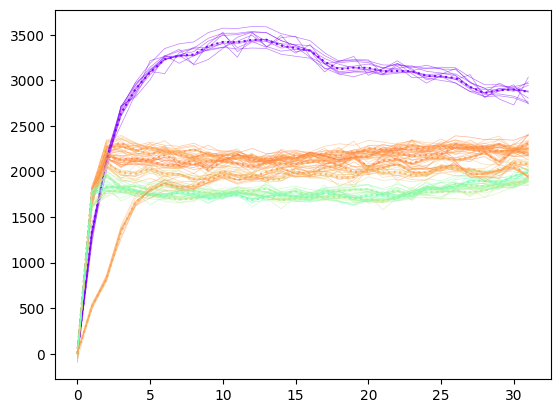

In [13]:
if synthetic_data:
    X_train_aug, y_train_aug, y_train_label_aug = augment_curves(X_train, festigkeit_train, label_train)
    print(X_train_aug.shape, y_train_aug.shape, y_train_label_aug.shape)

    cmap = matplotlib.colormaps['rainbow']
    max_fest = np.max(X_train[:,:,0])
    norm = matplotlib.colors.Normalize(0, max_fest)

    for i in range(10):
        plt.plot(np.arange(best_subsample_size), X_train[i,:,0], ':', c=cmap(festigkeit_train[i]/max_fest))
    for i in range(11*10):
        plt.plot(np.arange(best_subsample_size), X_train_aug[i,:,0], c=cmap(y_train_aug[i]/max_fest), alpha=0.5, linewidth=0.5)

    X_train          = X_train_aug
    festigkeit_train = y_train_aug
    label_train      = y_train_label_aug

<b><font color='lightgreen'> Daten skalieren

In [ ]:
tsMaxScale = helper.2()

X_train_scaled = tsMaxScale.fit_transform(X_train)
X2_train       = X_train_scaled[:,:,0]

X_test_scaled = tsMaxScale.transform(X_test)
X2_test       = X_test_scaled[:,:,0]

print(X2_train.shape, X2_test.shape)

festigkeit_train = festigkeit_train/SCALE
festigkeit_test  = festigkeit_test/SCALE

print(festigkeit_train.shape, festigkeit_test.shape)

(5280, 32) (120, 32)
(5280,) (120,)


<b><font color='darkred'> ____________________________________________________________________________________________________________________________________

<b><font color='lightgreen'> Darstellung der Schweisskurven X_train

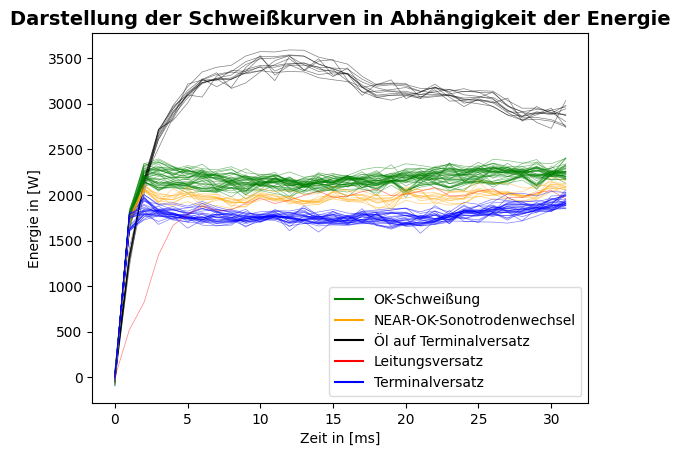

In [15]:
helper.plot_curves(X_train[:100,:,:], 0, label_train[:100], 'power')
# Komplette Kurve auf 26 (best_result['subsample_size'] Zeitpunkte in gleichem Abstand approximiert

<b><font color='lightgreen'> Kontrollanzeige t-SNE

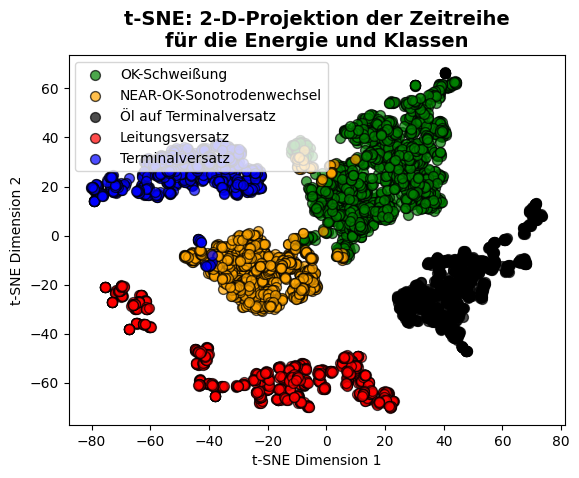

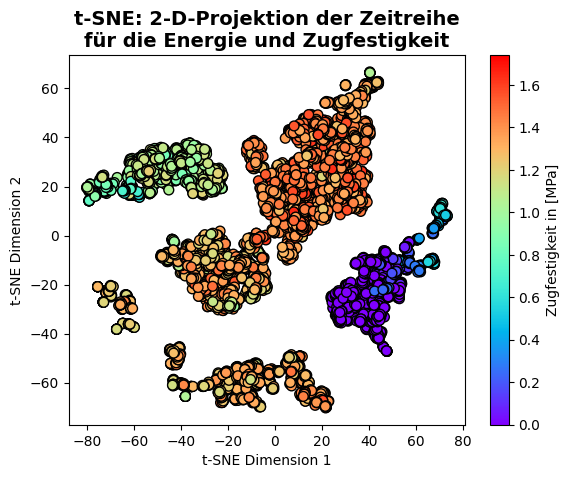

In [16]:
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'Energie', 'Klassen')
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'Energie', 'Zugfestigkeit')

<b><font color='darkred'>
SVM
-----------------
➔ kann nur 2-dimensionale Daten nutzen, daher Daten "flatten"     
➔ oder alternativ nur power verwenden (hier bessere Ergebnisse)     
  &emsp; <i> versuchsnr + zeitpunkt + power (daher die 0)

<b><font color='lightgreen'><h3> SVC - Support Vector Classification (Standardparameter)

In [17]:
modelSVC = svm.SVC(probability=True)
_ = modelSVC.fit(X2_train, label_train)

<b><font color='lightgreen'> Modellbewertung</b>

In [18]:
pred_train = modelSVC.predict(X2_train)
pred_test  = modelSVC.predict(X2_test)

helper.get_metric_table_class(label_train, pred_train, label_test, pred_test)

                        precision    recall  f1-score   support

                    ok      1.000     0.977     0.988        43
   near_ok_sonowechsel      0.905     1.000     0.950        19
            fehler_oel      1.000     1.000     1.000        17
fehler_leitungsversatz      1.000     1.000     1.000        17
  fehler_terminversatz      1.000     0.958     0.979        24

              accuracy                          0.983       120
             macro avg      0.981     0.987     0.983       120
          weighted avg      0.985     0.983     0.984       120



,Train,Test
Metric,,
Accuracy,0.985,0.983
Precision,0.985,0.985
Recall,0.985,0.983
F1-score,0.985,0.984


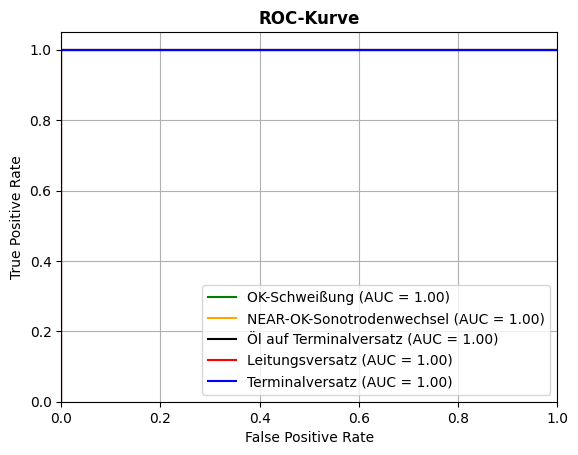

In [19]:
# Berechnung der Entscheidungsscores für die Testdaten
y_score = modelSVC.predict_proba(X2_test)
helper.plot_roc_curve(label_train, label_test, y_score)

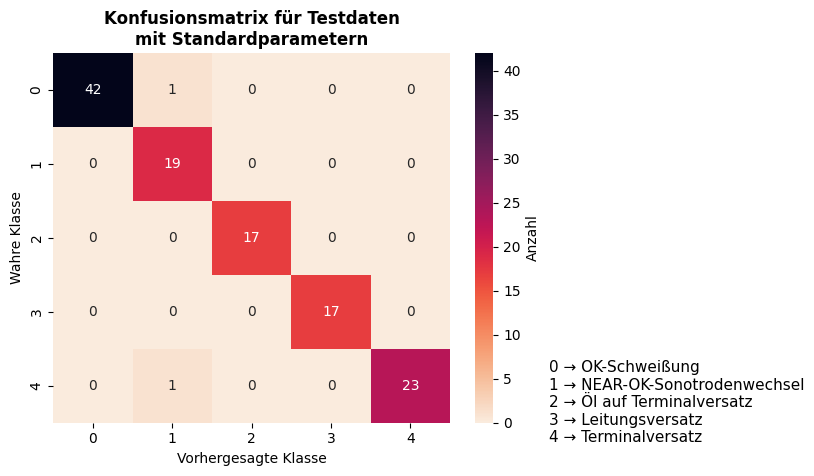

In [20]:
helper.plot_confusion(label_test, pred_test, 'Testdaten\nmit Standardparametern')

<b><font color='lightgreen'><h3> SVC - Support Vector Classification (Hyperparametersuche)

In [21]:
params = {
    'C': np.logspace(0, 4),
    'gamma': np.logspace(-5, 1),
    'kernel': ['rbf', 'linear']
}
random_search_svc = model_selection.RandomizedSearchCV(
    svm.SVC(probability=True), 
    params, 
    n_iter=30,
)
random_search_svc.fit(X2_train, label_train)
print("Beste Parameter:")
for param, value in random_search_svc.best_params_.items():
    print(f"  {param:6}: {value:8.3f}" if isinstance(value, float) else f"  {param:6}: {value:>8}")

Beste Parameter:
  kernel:   linear
  gamma :    0.002
  C     :   91.030


In [22]:
modelSVC_best = random_search_svc.best_estimator_
modelSVC_best

SVC(C=91.02981779915217, gamma=0.0015998587196060573, kernel='linear',
    probability=True)

<b><font color='lightgreen'> Modellbewertung</b>

In [23]:
pred_train = modelSVC_best.predict(X2_train)
pred_test  = modelSVC_best.predict(X2_test)

helper.get_metric_table_class(label_train, pred_train, label_test, pred_test)

                        precision    recall  f1-score   support

                    ok      1.000     0.977     0.988        43
   near_ok_sonowechsel      0.905     1.000     0.950        19
            fehler_oel      1.000     1.000     1.000        17
fehler_leitungsversatz      1.000     1.000     1.000        17
  fehler_terminversatz      1.000     0.958     0.979        24

              accuracy                          0.983       120
             macro avg      0.981     0.987     0.983       120
          weighted avg      0.985     0.983     0.984       120



,Train,Test
Metric,,
Accuracy,0.992,0.983
Precision,0.992,0.985
Recall,0.992,0.983
F1-score,0.992,0.984


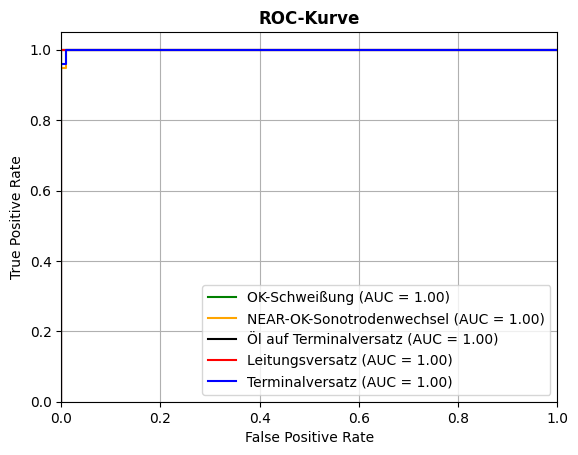

In [24]:
# Berechnung der Entscheidungsscores für die Testdaten
y_score = modelSVC_best.predict_proba(X2_test)
helper.plot_roc_curve(label_train, label_test, y_score)

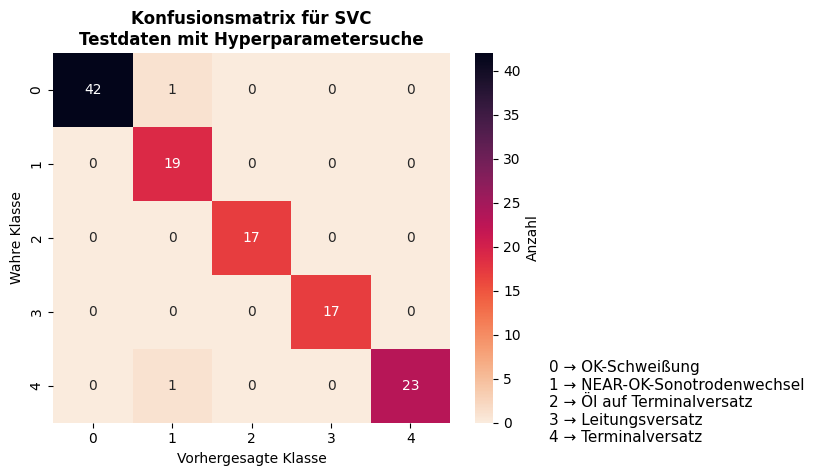

In [25]:
helper.plot_confusion(label_test, pred_test, 'SVC\nTestdaten mit Hyperparametersuche')

<b><font color='lightgreen'><h3> SVR - Support Vector Regression (Standardparameter)

In [26]:
regr = svm.SVR()
regr.fit(X2_train, festigkeit_train)
print("Training abgeschlossen")

Training abgeschlossen


<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

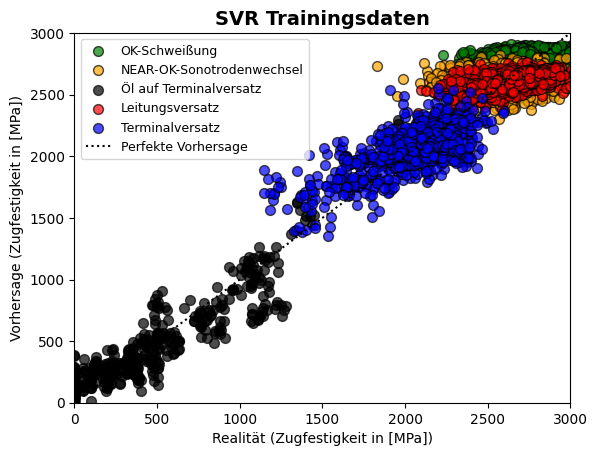

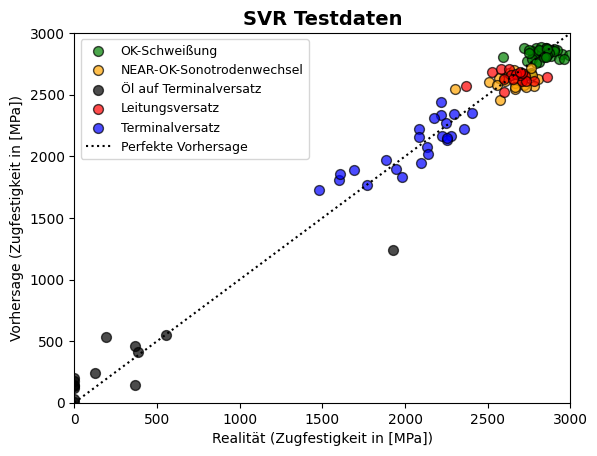

In [27]:
y_pred_train = regr.predict(X2_train)
y_pred_test  = regr.predict(X2_test)

helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'SVR Trainingsdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test, festigkeit_test, label_test, 'SVR Testdaten', 'mit Linie', SCALE)

<b><font color='lightgreen'> Modellbewertung</b>

In [28]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,28880.56,16943.09
RMSE,169.94,130.17
MAE,132.89,96.06
R²,0.97,0.98


<b><font color='lightgreen'><h3> SVR - Support Vector Regression (Hyperparametersuche) </b>

In [29]:
params = {
    'C': np.logspace(0, 4),
    'gamma': np.logspace(-5, 1),
    'kernel': ['rbf', 'linear'],
}
estimator = model_selection.RandomizedSearchCV(
    svm.SVR(),  
    params,     
    n_iter=50,
)
estimator.fit(X2_train, festigkeit_train)
estimator_best = estimator.best_estimator_
estimator_best

SVR(C=4.498432668969445, gamma=0.7906043210907702)

<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

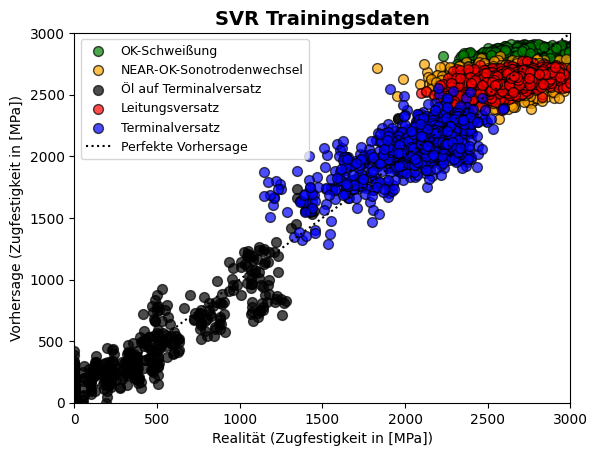

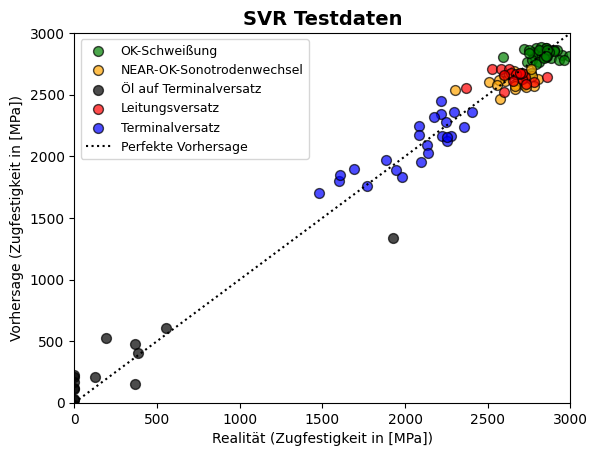

In [30]:
y_pred_train = estimator_best.predict(X2_train)
y_pred_test  = estimator_best.predict(X2_test)

helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'SVR Trainingsdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test, festigkeit_test, label_test, 'SVR Testdaten', 'mit Linie', SCALE)

<b><font color='lightgreen'> Modellbewertung</b>

In [31]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,28628.78,16101.37
RMSE,169.20,126.89
MAE,132.99,96.56
R²,0.97,0.98
